# DNN
Benchmarking incl. feature *duration*

In [141]:

import os.path

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

tf.random.set_seed(42)

## Data loading and preparation

### Load data and perform some processing on independent variables
- normalization on numeric features  
    ['age', 'duration', 'campaign', 'previous']  
    
- one-hot encoding on categorical features  
    ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [142]:
def get_processed_data(filename, encoder=None, split_target=True, oversample=False):
    """Returns processed data for modeling

    Args:
        filename (string): The name of the data file
        encoder (OneHotEncoder, optional): Fitted one-hot encoder. Creates and fit a new one if None
        split_target (bool, optional): Set to True if file contains target data. Defaults to True
        oversample (bool, optional): Oversamples the minority class if True

    Returns:
        Numpy array(s): Processed data
        OneHotEncoder: Fitted encoder if None was given
    """
    
    # determine file type
    extension = os.path.splitext(filename)[1][1:]
    
    # load all data
    data = pd.read_excel(filename)    
    print(f'Loaded data shape: {data.shape}')
        
    # drop duplicates
    data.drop_duplicates(inplace=True, ignore_index=True)
    print(f'W/o duplicates: {data.shape}')
    
    if split_target:
        predictors = data.iloc[:, 0:-1]
        target = data.iloc[:,-1:]
        
        if oversample:
            predictors, target = perform_oversampling(predictors, target)
    else:
        predictors = data
               
    # create one-hot encoder, if necessary
    categories = predictors.select_dtypes('object')
    if encoder == None:
            encoder = OneHotEncoder()
            encoder.fit(categories)  
        
    one_hot_cats = encoder.transform(categories).toarray()
    print(f'Encoded data shape: {one_hot_cats.shape}')
        
    # normalize numerical data
    nomalized_dict = {}
    for column, column_type in predictors.select_dtypes(exclude='object').iteritems():
        scaler = StandardScaler()
        nomalized_dict[column] = scaler.fit_transform(predictors[[column]]).flatten()
            
    normalized_nums = np.array(list(nomalized_dict.values())).transpose()
    
    # perform on-hot encoding on categorical data
    predictors = np.concatenate([normalized_nums, one_hot_cats], axis=1)
    
    if split_target:
        # convert target yes/no to 0/1
        target = target.applymap(lambda x: 1 if x == 'yes' else 0)
        return predictors, target.values, encoder
    else:
        return predictors

In [143]:

train_data, target, train_encoder = get_processed_data('train_file.xlsx')

print(f'train_data shape: {train_data.shape}')
print(f'target shape: {target.shape}')

Loaded data shape: (32910, 15)
W/o duplicates: (32902, 15)
Encoded data shape: (32902, 53)
train_data shape: (32902, 57)
target shape: (32902, 1)


### Split data for training and evaluation

In [144]:
# note: stratified target split due to imbalanced target data

x_train, x_val, y_train, y_val = train_test_split(train_data, target,
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=target)

print(f'X train shape: {x_train.shape}; X test shape {x_val.shape}')
print(f'Y train shape: {y_train.shape}; Y test shape {y_val.shape}')

X train shape: (26321, 57); X test shape (6581, 57)
Y train shape: (26321, 1); Y test shape (6581, 1)


### Determine class weight to handle imbalanced data

In [145]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train.squeeze())
print('Weight for class 0: {:.3f}'.format(class_weights[0]))
print('Weight for class 1: {:.3f}'.format(class_weights[1]))

class_weights = dict(zip([0, 1], class_weights))

Weight for class 0: 0.563
Weight for class 1: 4.437


## Training

### Baseline

In [146]:
def f1_score(y_true, y_pred):
    """Computes custom F1 score for Keras training

    Args:
        y_true (Numpy array): True values
        y_pred (Numpy array): Predicted values

    Returns:
        Float: The F1 score
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [147]:
BATCH_SIZE = 128

In [148]:
def get_baseline_dnn():
    """Returns a deep neuronal network; compiled

    Returns:
        Tensorflow object: DNN
    """
    model = Sequential([
        Dense(units=64, activation='relu', input_dim=x_train.shape[1]),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                         AUC(name='roc', curve='ROC'),
                                                                         AUC(name='prc', curve='PR'),
                                                                         f1_score])
    
    print(model.summary())
        
    return model

In [213]:
dnn_baseline = get_baseline_dnn()
baseline_history = dnn_baseline.fit(x_train, y_train,
                                    validation_data=(x_val, y_val),
                                    batch_size=BATCH_SIZE,
                                    epochs=40,
                                    verbose=0)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 64)                3712      
                                                                 
 dense_161 (Dense)           (None, 32)                2080      
                                                                 
 dense_162 (Dense)           (None, 16)                528       
                                                                 
 dense_163 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
None


#### Results

In [150]:
mpl.rcParams['figure.figsize'] = (6, 4)

In [151]:
def plot_history(history, train_label, val_label, title=''):
    """Plots the training history of the neuronal network
    """
    plt.plot(range(1, len(history.epoch)+1), history.history[train_label], label=train_label)
    plt.plot(range(1, len(history.epoch)+1), history.history[val_label], label=val_label)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend()
    plt.xlim(0, len(history.epoch))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(len(history.epoch)//10))
    plt.show()

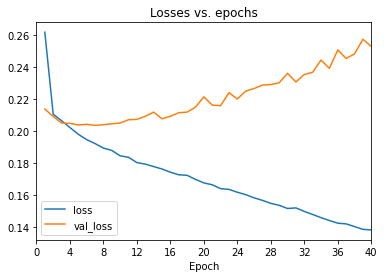

In [152]:
plot_history(baseline_history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

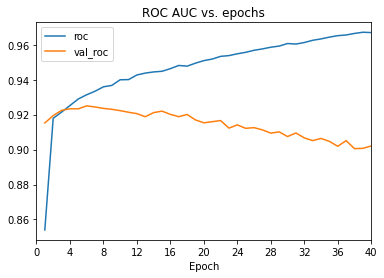

In [153]:
plot_history(baseline_history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

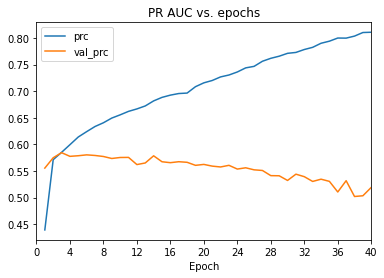

In [154]:
plot_history(baseline_history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

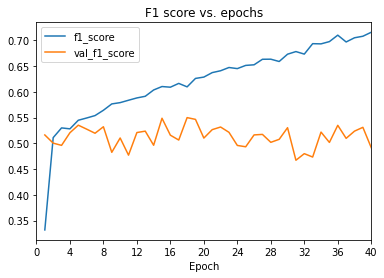

In [155]:
plot_history(baseline_history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

In [156]:
def plot_cm(labels, predictions, p=0.5, verbose=False):
    """Plots the confusion matrix based on the specified lables and predictions at p.
    
    Args:
      labels (_type_): _description_
      predictions (_type_): _description_
      p (float, optional): _description_. Defaults to 0.5.
    """
    cm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    if verbose:
        print(f'True negatives: {cm[0][0]}')
        print(f'False positives: {cm[0][1]}')
        print(f'False negatives: {cm[1][0]}')
        print(f'True positives: {cm[1][1]}')
        print(f'Total positives: {np.sum(cm[1])}')

In [157]:
def print_metrics(model):
    baseline_results = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(f'{name:<9}: {value:0.3f}')

loss     : 0.253
accuracy : 0.897
roc      : 0.902
prc      : 0.519
f1_score : 0.492


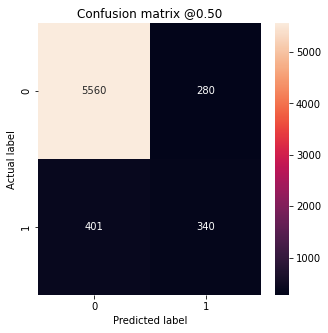

In [158]:
train_predictions_baseline = dnn_baseline.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_baseline = dnn_baseline.predict(x_val, batch_size=BATCH_SIZE)

print_metrics(dnn_baseline)
plot_cm(y_val, val_predictions_baseline, p=0.5)

ROC curve

In [159]:
def plot_roc(name, labels, predictions, **kwargs):
    """Plots the ROC curve
    """
    fp, tp, _ = metrics.roc_curve(labels, predictions)
        
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([-0.5,100.5])
    plt.grid(True)
    plt.legend(loc='lower right');
    ax = plt.gca()
    ax.set_aspect('equal')

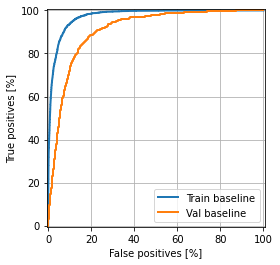

In [160]:
plot_roc("Train baseline", y_train, train_predictions_baseline)
plot_roc("Val baseline", y_val, val_predictions_baseline)

Precision/Recall (PR) curve

In [161]:
def plot_prc(name, labels, predictions, **kwargs):
    """Plots the precision/recall curve
    """
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0,1.05])
    plt.ylim([-0.05,1.05])
    plt.grid(True)
    plt.legend(loc='lower left');
    ax = plt.gca()
    ax.set_aspect('equal')

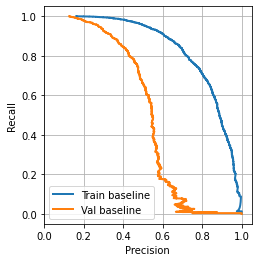

In [162]:
plot_prc("Train baseline", y_train, train_predictions_baseline)
plot_prc("Val baseline", y_val, val_predictions_baseline)

### Regularization
Drop-out layer to reduce overfitting

In [163]:
def get_regularized_dnn(learning_rate=0.001, drop_out_rate=0.5, print_summary=True):
    """Return a regularized DNN containing Dropout layers

    Args:
        learning_rate (float, optional): _description_. Defaults to 0.001.
        drop_out_rate (float, optional): _description_. Defaults to 0.5.
        print_summary (bool, optional): _description_. Defaults to True.

    Returns:
        Tensorflow object: The DNN
    """
    dropout_rate = drop_out_rate

    model = Sequential([
        Dense(units=64, activation='relu', input_dim=x_train.shape[1]),
        Dropout(dropout_rate),
        Dense(units=64, activation='relu'),
        Dropout(dropout_rate),
        Dense(units=32, activation='relu'),
        Dropout(dropout_rate),
        Dense(units=16, activation='relu'),
        Dense(units=8, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    opitimizer = Adam(learning_rate)
    model.compile(optimizer=opitimizer, loss='binary_crossentropy', metrics=['accuracy',
                                                                             AUC(name='roc', curve='ROC'),
                                                                             AUC(name='prc', curve='PR'),
                                                                             f1_score])
    if print_summary:
        print(model.summary())
    
    return model

In [164]:
dnn_regularized = get_regularized_dnn()
reg_history = dnn_regularized.fit(x_train, y_train,
                                  validation_data=(x_val, y_val),
                                  batch_size=BATCH_SIZE,
                                  epochs=40,
                                  verbose=1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 64)                3712      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 64)                4160      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 16)              

#### Results

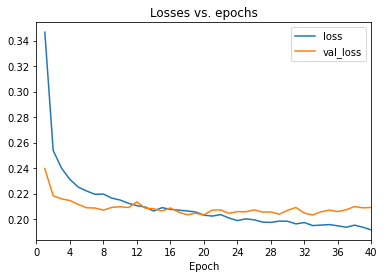

In [165]:
plot_history(reg_history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

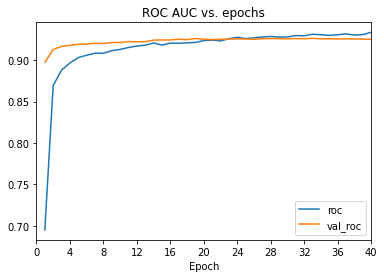

In [166]:
plot_history(reg_history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

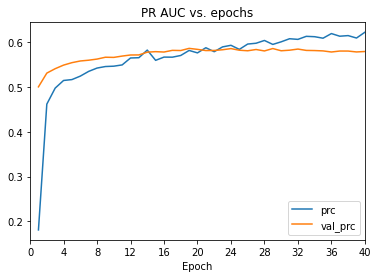

In [167]:
plot_history(reg_history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

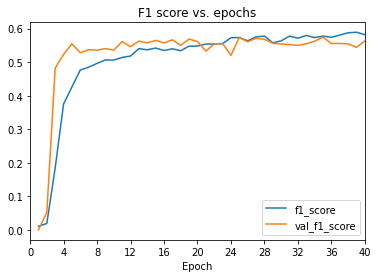

In [168]:
plot_history(reg_history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

loss     : 0.209
accuracy : 0.899
roc      : 0.925
prc      : 0.579
f1_score : 0.563


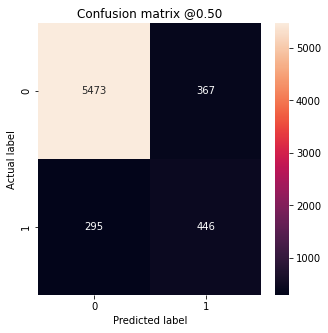

In [169]:
train_predictions_reg = dnn_regularized.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_reg = dnn_regularized.predict(x_val, batch_size=BATCH_SIZE)

print_metrics(dnn_regularized)
plot_cm(y_val, val_predictions_reg, p=0.5)

ROC

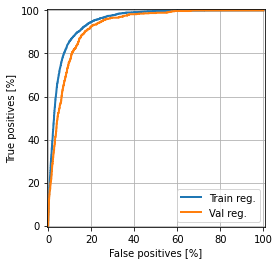

In [170]:
plot_roc("Train reg.", y_train, train_predictions_reg)
plot_roc("Val reg.", y_val, val_predictions_reg)

PR curve

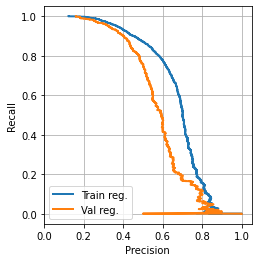

In [171]:
plot_prc("Train reg.", y_train, train_predictions_reg)
plot_prc("Val reg.", y_val, val_predictions_reg)

### Class weights

In [172]:
def compute_train_val_metrics(model):
    """Prints metrics for training and evaluation data

    Args:
        model : The model to evaluate
    """
    train_results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    val_results = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
    
    train_val_results = np.vstack([np.array(train_results).transpose(),
                                   np.array(val_results).transpose()]).transpose()
    
    result_df = pd.DataFrame(columns=['Training', 'Validation'], index=model.metrics_names, data=train_val_results)
    
    return pd.DataFrame(columns=['Val'], index=model.metrics_names, data=val_results)

In [173]:
def grid_search_dnn_weighted():
    learning_rates = [0.001, 0.005, 0.01]
    drop_out_rates = [0.4, 0.5, 0.6, 0.7]
    
    search_metrics = pd.DataFrame()
    
    for learning_rate in learning_rates:
        for drop_out_rate in drop_out_rates:
           
            dnn_weighted = get_regularized_dnn(learning_rate, drop_out_rate, print_summary=False)
            dnn_weighted.fit(x_train, y_train,
                             validation_data=(x_val, y_val),
                             batch_size=BATCH_SIZE,
                             epochs=100,
                             class_weight=class_weights,
                             verbose=0)

            dnn_weighted.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
            
            metrics = compute_train_val_metrics(dnn_weighted).transpose()
            metrics.insert(0, 'lr/dor', f'{learning_rate}/{drop_out_rate}')
            
            if search_metrics.empty:
                search_metrics = metrics
            else:
                search_metrics = pd.concat([search_metrics, metrics.reset_index(drop=True)], axis=0)
                
    print(search_metrics.reset_index(drop=True).round(3))

grid_search_dnn_weighted()

       lr/dor   loss  accuracy    roc    prc  f1_score
0   0.001/0.4  0.312     0.847  0.922  0.585     0.555
1   0.001/0.5  0.325     0.834  0.926  0.580     0.540
2   0.001/0.6  0.346     0.838  0.925  0.568     0.549
3   0.001/0.7  0.303     0.870  0.920  0.588     0.586
4   0.005/0.4  0.340     0.831  0.918  0.580     0.536
5   0.005/0.5  0.326     0.842  0.923  0.590     0.555
6   0.005/0.6  0.316     0.849  0.926  0.572     0.561
7   0.005/0.7  0.349     0.845  0.917  0.560     0.557
8    0.01/0.4  0.339     0.845  0.911  0.486     0.557
9    0.01/0.5  0.372     0.841  0.906  0.455     0.549
10   0.01/0.6  0.324     0.829  0.922  0.574     0.537
11   0.01/0.7  0.352     0.830  0.912  0.465     0.541


In [174]:
dnn_weighted = get_regularized_dnn()
weighted_history = dnn_weighted.fit(x_train, y_train,
                                    validation_data=(x_val, y_val),
                                    batch_size=BATCH_SIZE,
                                    epochs=40,
                                    class_weight=class_weights,
                                    verbose=1)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 64)                3712      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 64)                4160      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 dense_150 (Dense)           (None, 32)                2080      
                                                                 
 dropout_66 (Dropout)        (None, 32)                0         
                                                                 
 dense_151 (Dense)           (None, 16)              

#### Results

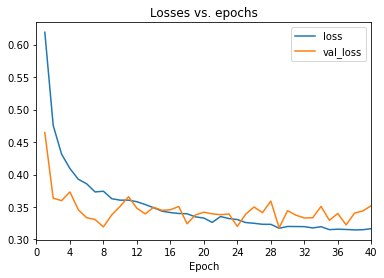

In [175]:
plot_history(weighted_history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

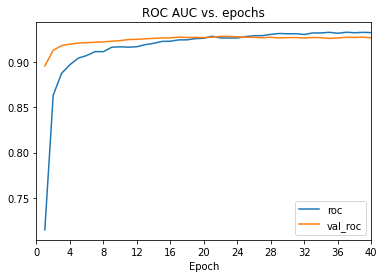

In [176]:
plot_history(weighted_history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

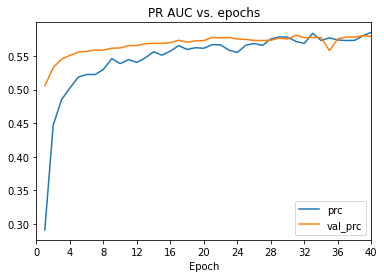

In [177]:
plot_history(weighted_history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

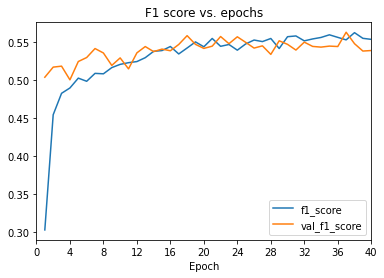

In [178]:
plot_history(weighted_history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

loss     : 0.352
accuracy : 0.826
roc      : 0.926
prc      : 0.579
f1_score : 0.539


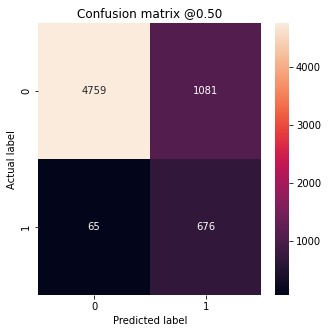

In [179]:
train_predictions_weighted = dnn_weighted.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_weighted = dnn_weighted.predict(x_val, batch_size=BATCH_SIZE)

print_metrics(dnn_weighted)
plot_cm(y_val, val_predictions_weighted, p=0.5)

ROC

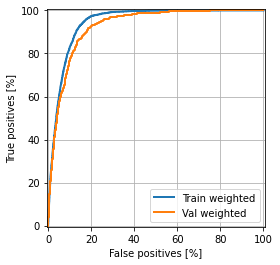

In [180]:
plot_roc("Train weighted", y_train, train_predictions_weighted)
plot_roc("Val weighted", y_val, val_predictions_weighted)

PR curve

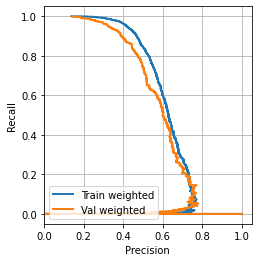

In [181]:
plot_prc("Train weighted", y_train, train_predictions_weighted)
plot_prc("Val weighted", y_val, val_predictions_weighted)

### Oversampling

In [182]:
def perform_oversampling(x, y):     
    print('Orig target balance:')
    print(y.y.value_counts())
    
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    x, y = ros.fit_resample(x, y)
    
    print('Resampled target balance:')
    print(y.y.value_counts())
    
    return x, y

In [183]:
train_data_os, target_os, train_encoder_os = get_processed_data('train_file.xlsx', oversample=True)

print(f'train_data shape: {train_data_os.shape}')
print(f'target shape: {target_os.shape}')

x_train_os, x_val_os, y_train_os, y_val_os = train_test_split(train_data_os, target_os,
                                                              train_size=0.8,
                                                              shuffle=True,
                                                              random_state=42,
                                                              stratify=target_os)

print(f'X train shape: {x_train_os.shape}; X test shape {x_val_os.shape}')
print(f'Y train shape: {y_train_os.shape}; Y test shape {y_val_os.shape}')

Loaded data shape: (32910, 15)
W/o duplicates: (32902, 15)
Orig target balance:
no     29195
yes     3707
Name: y, dtype: int64
Resampled target balance:
no     29195
yes    29195
Name: y, dtype: int64
Encoded data shape: (58390, 53)
train_data shape: (58390, 57)
target shape: (58390, 1)
X train shape: (46712, 57); X test shape (11678, 57)
Y train shape: (46712, 1); Y test shape (11678, 1)


In [184]:
dnn_os = get_regularized_dnn()
os_history = dnn_os.fit(x_train_os, y_train_os,
                         validation_data=(x_val_os, y_val_os),
                         batch_size=BATCH_SIZE,
                         epochs=60,
                         verbose=1)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 64)                3712      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_156 (Dense)           (None, 32)                2080      
                                                                 
 dropout_69 (Dropout)        (None, 32)                0         
                                                                 
 dense_157 (Dense)           (None, 16)              

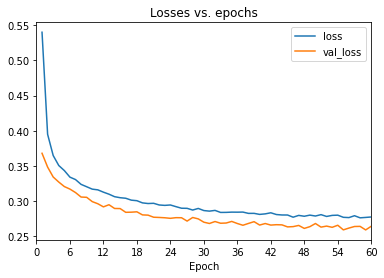

In [185]:
plot_history(os_history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

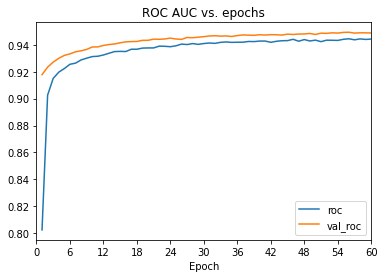

In [186]:
plot_history(os_history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

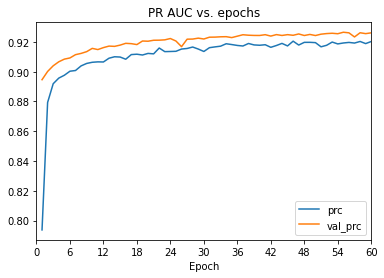

In [187]:
plot_history(os_history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

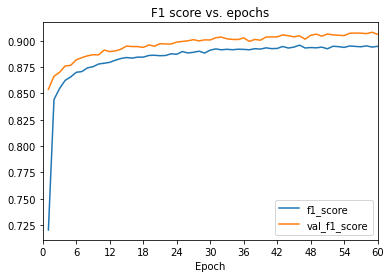

In [188]:
plot_history(os_history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

In [189]:
def print_metrics_os(model):
    baseline_results = model.evaluate(x_val_os, y_val_os, batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(f'{name:<9}: {value:0.3f}')

loss     : 0.264
accuracy : 0.901
roc      : 0.949
prc      : 0.926
f1_score : 0.906


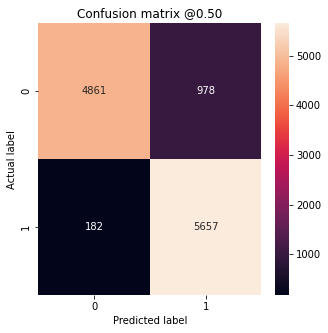

In [190]:
train_predictions_os = dnn_os.predict(x_train_os, batch_size=BATCH_SIZE)
val_predictions_os = dnn_os.predict(x_val_os, batch_size=BATCH_SIZE)

print_metrics_os(dnn_os)
plot_cm(y_val_os, val_predictions_os, p=0.5)

loss     : 0.569
accuracy : 0.719
roc      : 0.939
prc      : 0.600
f1_score : 0.439


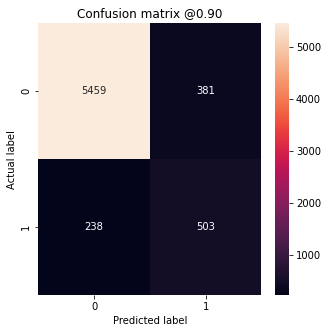

In [212]:
val_predictions_os_on_orig = dnn_os.predict(x_val, batch_size=BATCH_SIZE)

print_metrics(dnn_os)
plot_cm(y_val, val_predictions_os_on_orig, p=0.9)

ROC

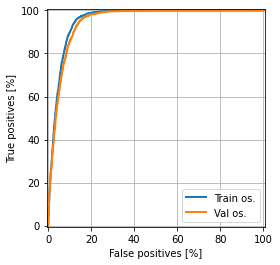

In [192]:
plot_roc("Train os.", y_train_os, train_predictions_os)
plot_roc("Val os.", y_val_os, val_predictions_os)

PR curve

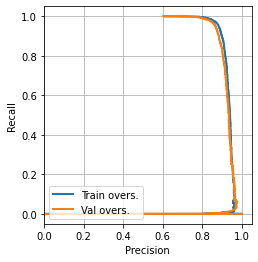

In [193]:
plot_prc("Train overs.", y_train_os, train_predictions_os)
plot_prc("Val overs.", y_val_os, val_predictions_os)

## Summary

| DNN | Accuracy | ROC AUC | PR AUC | F1 score |
| :- | :- | :- | :- | :- |
| Baseline* |0.897|0.902|0.519|0.492|
| Regularized |0.899|0.925|0.579|0.563|
| Class weights |0.826|0.926|0.579|0.539|
| Oversampling |0.901|0.949|0.926|0.906|

\* Overfitting

## Test predictions

In [194]:
x_test = get_processed_data('test_file.xlsx', encoder=train_encoder, split_target=False)
x_test.shape

Loaded data shape: (40, 14)
W/o duplicates: (40, 14)
Encoded data shape: (40, 53)


(40, 57)

In [224]:
threshold = 0.5

test_predictions = {}
test_predictions['dnn_base'] = np.where(dnn_baseline.predict(x_test) > threshold, 1, 0).squeeze()
test_predictions['dnn_regularized'] = np.where(dnn_regularized.predict(x_test) > threshold, 1, 0).squeeze()
test_predictions['dnn_class_weighted'] = np.where(dnn_weighted.predict(x_test) > threshold, 1, 0).squeeze()
test_predictions['dnn_oversampling'] = np.where(dnn_os.predict(x_test) > threshold, 1, 0).squeeze()
test_pred_df = pd.DataFrame().from_dict(test_predictions)
test_pred_df.head()

,dnn_base,dnn_regularized,dnn_class_weighted,dnn_oversampling
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,1,0
4,0,0,0,0


In [225]:
test_pred_df.to_csv('test_predictions_bm.csv', index=False)